# Assignment 2

Akos Engelmann, Simon Jasansky

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# we don't need to load the y_train and y_test, as we will not use the labels of the image
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

In [3]:
# split the test data into test and validation
data = np.concatenate((x_train, x_test))
print(data.shape)
# the shape is as expected, 60000 samples with 32x32 pictures, with 3 layers (RGB)

(60000, 32, 32, 3)


(32, 32, 3)
(32, 3)
(3,)
[59 62 63]


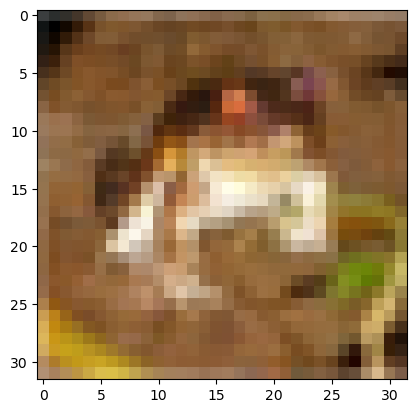

In [4]:
# first picture
print(data[0].shape)

# first row (or column, idk) of pixels of the picture
print(data[0][0].shape)

# first pixel of the first row/column of the picture (RGB values)
print(data[0][0][0].shape)
print(data[0][0][0])

# print the first picture
plt.imshow(data[0])
plt.show()

In [5]:
# do normalization over each image (use L2 norm)
data = data.astype("float32")
data = tf.keras.utils.normalize(data, axis = 1, order = 2)

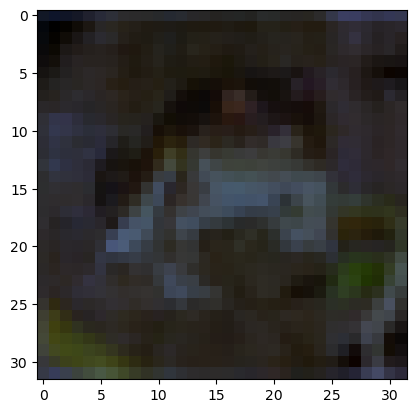

In [6]:
# print the first picture again (normalized)
plt.imshow(data[0])
plt.show()

In [7]:
# reshuffle before splitting data
np.random.shuffle(data)

# split into train, test and validation sets
train = data[:48000]
test = data[48000:54000]
valid = data[54000:]

print(train.shape)
print(test.shape)
print(valid.shape)

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [8]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
# shape now: 32x32x3

x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
# shape now: 32x32x8

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#shape now: 16x16x8 - since we use 1x1 strides, it's gonna subtract only 1 each dimensions
# 1 2 3 4       2 3 4
# 1 2 3 4 ---»  2 3 4
# 1 2 3 4 ---»  2 3 4
# 1 2 3 4
# therefore it should be 31x31x8. BUT the plan says it subtracts 2 each dimension... but why?
#
# it would be 16x16x8 if the strides would be 2x2
# 2 4
# 2 4
#
# One more thing: The plan says that 'always padding same', but it keeps the size the same at maxpooling, so maybe just for conv2d?
#
# But then UpSampling wouldn't work, bc it makes 2x2 pixels from one.. so the 'always stride 1' also works just for the conv2d? wth Kurt


x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
#shape now: 

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#shape now: 

# Latent space is a Conv2D layer, after the MaxPooling and before the UpSampling
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)

x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
# shape now: 

x = tf.keras.layers.Conv2DTranspose(12, (3, 3), activation='relu', padding='same')(x)
# shape now: 

x = tf.keras.layers.UpSampling2D((2, 2))(x)
# shape now: 

output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)
# shape now: 32x32x3

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-14 14:58:02.882923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 14:58:02.883645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse')
pic_CAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 LATENT_SPACE (Conv2D)       (None, 8, 8, 16)          1744  

In [10]:
# train the model
pic_CAE.fit(x = train,
           y = train,
           epochs=10,
           batch_size=64,
           shuffle=True,
           validation_data=(test, test))

Epoch 1/10


2022-11-14 14:58:38.248238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 14:58:38.599036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


748/750 [============================>.] - ETA: 0s - loss: 0.0020

2022-11-14 14:58:49.861980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 12s 16ms/step - loss: 0.0020 - val_loss: 9.8600e-04
Epoch 2/10
750/750 [==============================] - 11s 15ms/step - loss: 8.9449e-04 - val_loss: 8.5369e-04
Epoch 3/10
750/750 [==============================] - 11s 15ms/step - loss: 8.0949e-04 - val_loss: 7.8874e-04
Epoch 4/10
750/750 [==============================] - 11s 15ms/step - loss: 7.5668e-04 - val_loss: 7.4282e-04
Epoch 5/10
750/750 [==============================] - 11s 15ms/step - loss: 7.1812e-04 - val_loss: 7.1242e-04
Epoch 6/10
750/750 [==============================] - 12s 15ms/step - loss: 6.8896e-04 - val_loss: 6.8786e-04
Epoch 7/10
750/750 [==============================] - 11s 15ms/step - loss: 6.6161e-04 - val_loss: 6.6153e-04
Epoch 8/10
750/750 [==============================] - 12s 16ms/step - loss: 6.3838e-04 - val_loss: 6.5113e-04
Epoch 9/10
750/750 [==============================] - 12s 15ms/step - loss: 6.2400e-04 - val_loss: 6.2454e-04
Epoch 10/10
750/750 [====

In [11]:
pic_CAE.save("pic_cae.h5")

In [12]:
# make model to get intermediate representation in latent space
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)

In [13]:
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
encoded_pic = encoded_pic.reshape((len(test), 8*8*16))
encoded_pic.shape

 93/188 [=============>................] - ETA: 0s

2022-11-14 15:00:40.798888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 0s 2ms/step


(6000, 1024)

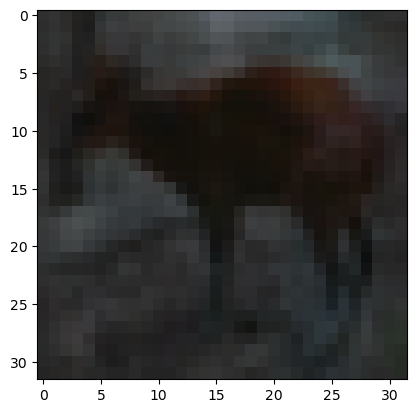

In [14]:
plt.imshow(test[0])
plt.show()


 22/188 [==>...........................] - ETA: 0s

2022-11-14 15:01:07.945614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 1s 5ms/step


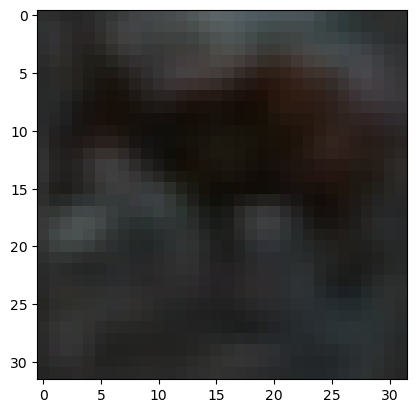

In [15]:
# get the reconstructed pics and visualize them
reconstructed_pics = pic_CAE.predict(test)

plt.imshow(reconstructed_pics[0])
plt.show()